In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
def grabPaths(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='path').astype(str)
    labels = pd.Series(labels, name='label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [3]:
# Read datasets

# List directories of files
train_image_dir = Path('../input/asl-alphabet/asl_alphabet_train')
train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

test_image_dir = Path('../input/asl-alphabet/asl_alphabet_test')
test_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

# Create dataframe of {paths, labels}
train_df = grabPaths(train_filepaths)
test_df = grabPaths(test_filepaths)


# Import another dataset (to train model on various data)
temp_image_dir = Path('../input/asl-alphabet-test')
temp_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

temp_df = grabPaths(temp_filepaths)
train_df = pd.concat((train_df, temp_df))


df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

In [4]:
# Classes counts
print("Classes counts")
counts = pd.concat((train_df, test_df)).iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
A          9000
B          9000
C          9000
D          9000
E          9000
F          9000
G          9000
H          9000
I          9000
J          9000
K          9000
L          9000
M          9000
N          9000
O          9000
P          9000
Q          9000
R          9000
S          9000
T          9000
U          9000
V          9000
W          9000
X          9000
Y          9000
Z          9000
del        9000
nothing    9000
space      9000
Name: label, dtype: int64


Dataset size = 261000 samples


In [5]:
# Preprocess data

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
#     horizontal_flip = True,
#     brightness_range=(0.75, 1.3),
#     rotation_range=20,    
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
#     horizontal_flip = True,
#     brightness_range=(0.75, 1.3),
#     rotation_range=20,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
)

Found 139200 validated image filenames belonging to 29 classes.
Found 34800 validated image filenames belonging to 29 classes.
Found 87000 validated image filenames belonging to 29 classes.


In [6]:
# Neural network architecture

pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

2021-10-30 21:41:30.544898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 21:41:30.638215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 21:41:30.638925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 21:41:30.640029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
# Compile model

adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

model.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Fit model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=3,
 )

2021-10-30 21:41:34.569801: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2021-10-30 21:41:38.188363: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2175/2175 [==============================] - 887s 404ms/step - loss: 0.1892 - accuracy: 0.9409 - val_loss: 0.1174 - val_accuracy: 0.9631
Epoch 2/3
2175/2175 [==============================] - 540s 248ms/step - loss: 0.0833 - accuracy: 0.9752 - val_loss: 0.0899 - val_accuracy: 0.9747
Epoch 3/3
2175/2175 [==============================] - 567s 260ms/step - loss: 0.0787 - accuracy: 0.9788 - val_loss: 0.0831 - val_accuracy: 0.9793


In [9]:
# Evaluate Model
model.evaluate(test_images, verbose=1)

1360/1360 [==============================] - 316s 232ms/step - loss: 0.0761 - accuracy: 0.9806


[0.07610735297203064, 0.9805517196655273]

In [10]:
model.save('Sign Language ALS Classifier.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


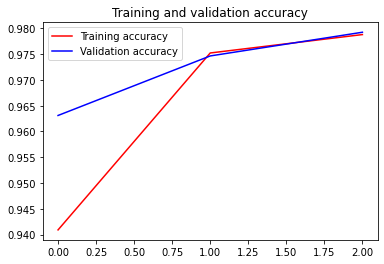

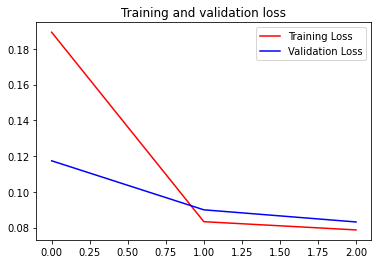

In [11]:
# Training & Validation <> Loss & Accuracy

%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

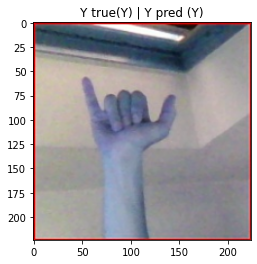

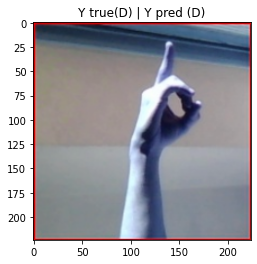

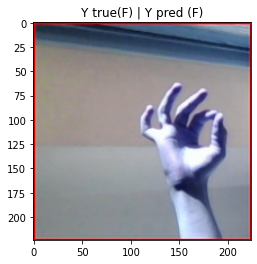

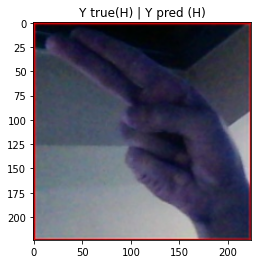

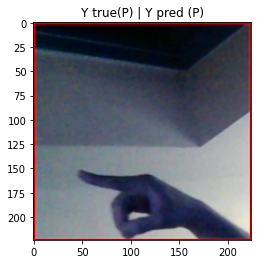

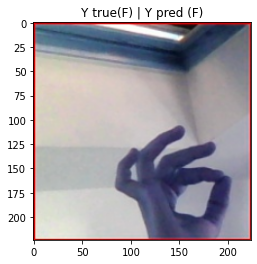

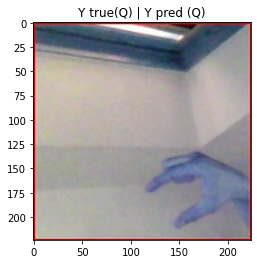

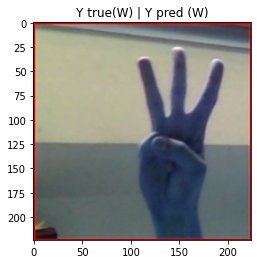

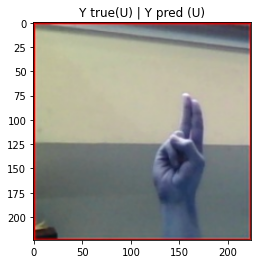

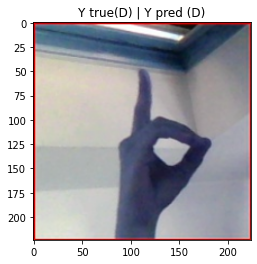

In [12]:
# Visualize some classifications

from tensorflow.keras.preprocessing import image

labels = list(train_images.class_indices)


for i in np.random.randint(test_df.shape[0], size=10):
    img = cv2.imread(test_df.iloc[i,0])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    images = np.vstack([img])
    y_pred = np.argmax(model.predict(images,verbose=0), axis=1)[0]
    y_true = test_df.iloc[i,1]
    plt.title(f"Y true({y_true}) | Y pred ({labels[y_pred]})")
    plt.show()